In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os
file_names = [data_dir + file for file in os.listdir(data_dir) ]
file_names

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

In [ ]:
def get_lines(filename):
  with open(filename,"r") as f:
    return f.readlines()

In [ ]:
r = get_lines(data_dir + "train.txt")

In [ ]:
def preprocess_text(filename):
  input = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []
  for line in input:
    if line.startswith("###"):
      abs_id = line
      abstract_lines = ""
    elif line.isspace():
      abs = abstract_lines.splitlines()
      for num,l in enumerate(abs):
        line_data = {}
        target = l.split("\t")
        line_data["target"] = target[0]
        line_data["text"] = target[1]
        line_data["line_number"] = num
        line_data["total_lines"] = len(abs)-1
      abstract_samples.append(line_data)
    else:
      abstract_lines+=line
  return abstract_samples

In [ ]:
train_samples = preprocess_text(data_dir + "train.txt")
test_samples = preprocess_text(data_dir + "test.txt")
dev_samples = preprocess_text(data_dir+"dev.txt")

In [ ]:
train_samples[:10]

[{'target': 'CONCLUSIONS',
  'text': 'Low-dose oral prednisolone had both a short-term and a longer sustained effect resulting in less knee pain , better physical function , and attenuation of systemic inflammation in older patients with knee OA ( ClinicalTrials.gov identifier NCT@ ) .',
  'line_number': 11,
  'total_lines': 11},
 {'target': 'CONCLUSIONS',
  'text': 'Results further suggest that attention maintenance on food relates to eating motivation when in a neutral affective state , and might therefore be a cognitive mechanism contributing to increased food intake in general , but maybe not during sad mood .',
  'line_number': 10,
  'total_lines': 10},
 {'target': 'BACKGROUND',
  'text': 'http://www.clinicaltrials.gov number NCT@ .',
  'line_number': 14,
  'total_lines': 14},
 {'target': 'BACKGROUND',
  'text': 'Data management and statistical analyses were conducted independently by Vertical ( Paris , France ) .',
  'line_number': 16,
  'total_lines': 16},
 {'target': 'CONCLUSIO

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
test_df = pd.DataFrame(test_samples)
dev_df = pd.DataFrame(dev_samples)

<Axes: ylabel='Frequency'>

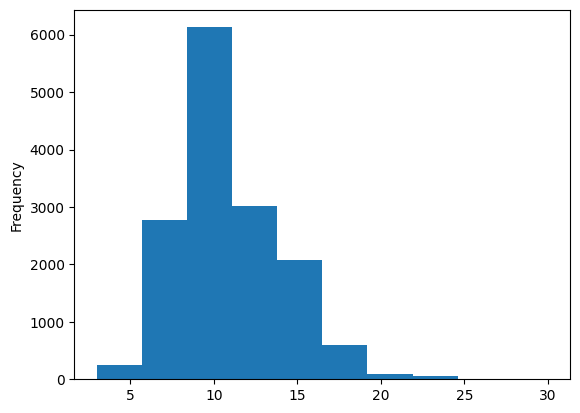

In [ ]:
train_df.total_lines.plot.hist()

In [ ]:
train_sentences = train_df["text"].tolist()
val_sentences = dev_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(15000, 2500, 2500)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=True)
train_labels = encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1))
train_labels

<15000x5 sparse matrix of type '<class 'numpy.float64'>'
	with 15000 stored elements in Compressed Sparse Row format>

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(dev_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([1, 1, 0, ..., 1, 1, 1])

In [ ]:
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

model_0 = Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ("clf",MultinomialNB())
])

model_0.fit(train_sentences,train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0.score(val_sentences,val_labels_encoded)

0.9328

In [ ]:
base_preds = model_0.predict(test_sentences)
base_preds

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2023-07-17 09:19:05--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.9’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-07-17 09:19:05 (56.4 MB/s) - ‘helper_functions.py.9’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
base_results= calculate_results(y_true = test_labels_encoded,y_pred=base_preds)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
base_results

{'accuracy': 93.64,
 'precision': 0.9176293982279466,
 'recall': 0.9364,
 'f1': 0.926836847251855}

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

20.316933333333335

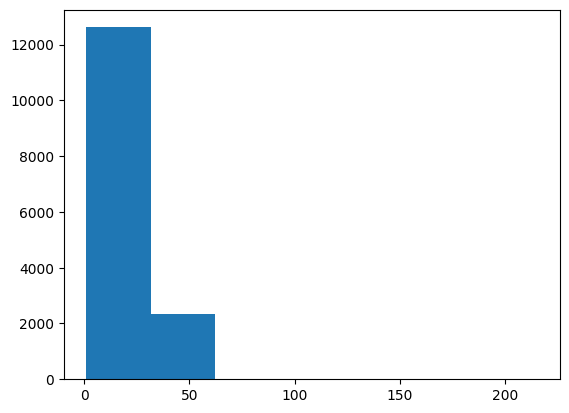

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);


In [ ]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

40

In [ ]:
max(sent_lens)

215

In [ ]:
from tensorflow.keras.layers import TextVectorization

text_vectorizer = TextVectorization(max_tokens=68000, # number of words in vocabulary
                                    output_sequence_length=40) # desired output length of vectorized sequences

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
Netherlands Trial Register NTR@ .

Length of text: 5

Vectorized text:
[[633  31 268 265   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]]


In [ ]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocabulary: {len(rct_20k_text_vocab)}"),
print(f"Most common words in the vocabulary: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocabulary: {rct_20k_text_vocab[-5:]}")

Number of words in vocabulary: 20772
Most common words in the vocabulary: ['', '[UNK]', 'the', 'of', 'and']
Least common words in the vocabulary: ['aads', 'aadrenoceptor', 'aad', 'aaca', 'aaaaiawc']


In [ ]:
text_vectorizer.get_config()

{'name': 'text_vectorization_2',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 40,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 20772}

In [ ]:
token_embed = tf.keras.layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding")


In [ ]:
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")
print(f"Embedded sentence shape: {embedded_sentence.shape}")

Sentence before vectorization:
Netherlands Trial Register NTR@ .

Sentence after vectorization (before embedding):
[[633  31 268 265   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]]

Sentence after embedding:
[[[-0.04484637  0.0224561  -0.03955982 ...  0.02294916  0.01845006
   -0.00610786]
  [ 0.00117385 -0.04322764  0.03286388 ...  0.03471163  0.01984142
    0.04045517]
  [ 0.02267306  0.00483109  0.02750143 ... -0.00656642 -0.01248432
    0.03167596]
  ...
  [-0.03977663  0.00201302  0.02011731 ... -0.04538285 -0.04412564
   -0.00078707]
  [-0.03977663  0.00201302  0.02011731 ... -0.04538285 -0.04412564
   -0.00078707]
  [-0.03977663  0.00201302  0.02011731 ... -0.04538285 -0.04412564
   -0.00078707]]]

Embedded sentence shape: (1, 40, 128)


In [ ]:
one_hot_encoder = OneHotEncoder(sparse=False)

train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(dev_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_data = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
inputs = tf.keras.layers.Input(shape=(1,),dtype='string')
x = text_vectorizer(inputs)
x = token_embed(x)
x = tf.keras.layers.Conv1D(64,5,activation='tanh')(x)
x = tf.keras.layers.Conv1D(32,5,activation='tanh')(x)
x = tf.keras.layers.GlobalMaxPooling1D()(x)

outputs = tf.keras.layers.Dense(5,activation='sigmoid')(x)
model_1 = tf.keras.Model(inputs,outputs)

model_1.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 1)]               0         
                                                                 
 text_vectorization_2 (TextV  (None, 40)               0         
 ectorization)                                                   
                                                                 
 token_embedding (Embedding)  (None, 40, 128)          2658816   
                                                                 
 conv1d_5 (Conv1D)           (None, 36, 64)            41024     
                                                                 
 conv1d_6 (Conv1D)           (None, 32, 32)            10272     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 32)               0         
 balMaxPooling1D)                                         

In [ ]:
model_1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
result = model_1.fit(train_dataset,
                     epochs=10,
                     validation_data=valid_dataset,
                     validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/10
469/469 [==============================] - 43s 88ms/step - loss: 0.2357 - accuracy: 0.9395 - val_loss: 0.1925 - val_accuracy: 0.9464
Epoch 2/10
469/469 [==============================] - 22s 47ms/step - loss: 0.1027 - accuracy: 0.9669 - val_loss: 0.1867 - val_accuracy: 0.9598
Epoch 3/10
469/469 [==============================] - 24s 51ms/step - loss: 0.0637 - accuracy: 0.9780 - val_loss: 0.1966 - val_accuracy: 0.9643
Epoch 4/10
469/469 [==============================] - 22s 47ms/step - loss: 0.0477 - accuracy: 0.9842 - val_loss: 0.2030 - val_accuracy: 0.9643
Epoch 5/10
469/469 [==============================] - 23s 48ms/step - loss: 0.0419 - accuracy: 0.9861 - val_loss: 0.2087 - val_accuracy: 0.9598
Epoch 6/10
469/469 [==============================] - 22s 46ms/step - loss: 0.0388 - accuracy: 0.9873 - val_loss: 0.2139 - val_accuracy: 0.9598
Epoch 7/10
469/469 [==============================] - 23s 49ms/step - loss: 0.0363 - accuracy: 0.9885 - val_loss: 0.2265 - val_accuracy:

In [ ]:
model_1_preds= model_1.predict(test_data)
model_1_probs = tf.argmax(model_1_preds,axis=1)
model_1_results = calculate_results(y_true=test_labels_encoded,y_pred=model_1_probs)

79/79 [==============================] - 1s 6ms/step


In [ ]:
import tensorflow_hub as hub

tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]} (truncated output)...\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
ClinicalTrials.gov : NCT@ ; http://clinicaltrials.gov/show/NCT@ ( Archived by WebCite at http://www.webcitation.org/@R@gDAK@K ) .

Sentence after embedding:
[ 0.04547628  0.06453998  0.07804038 -0.06285995 -0.0402746   0.05788327
  0.06285135  0.04468273 -0.00465066  0.00782256  0.00409762  0.04163318
 -0.00448361  0.01399383  0.02480791  0.01129121 -0.00403459 -0.04336949
 -0.00627056 -0.01102115 -0.05389664  0.07449102 -0.07122834 -0.04326382
 -0.03162292  0.02194191 -0.01501887  0.03743997 -0.04039709  0.03720411] (truncated output)...

Length of sentence embedding:
512


In [ ]:
inputs = tf.keras.layers.Input(shape=[],dtype='string')
pre = tf_hub_embedding_layer(inputs)
x = tf.keras.layers.Dense(128,activation='tanh')(pre)
outputs = tf.keras.layers.Dense(5,activation='sigmoid')(x)
model_2 = tf.keras.Model(inputs,outputs)

In [ ]:
model_2.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None,)]                 0         
                                                                 
 universal_sentence_encoder   (None, 512)              256797824 
 (KerasLayer)                                                    
                                                                 
 dense_14 (Dense)            (None, 128)               65664     
                                                                 
 dense_15 (Dense)            (None, 5)                 645       
                                                                 
Total params: 256,864,133
Trainable params: 66,309
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
model_2.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

model_2.fit(train_dataset,
                     epochs=10,
                     validation_data=valid_dataset,
                     validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/10
469/469 [==============================] - 10s 16ms/step - loss: 0.2326 - accuracy: 0.9436 - val_loss: 0.1676 - val_accuracy: 0.9509
Epoch 2/10
469/469 [==============================] - 7s 15ms/step - loss: 0.1349 - accuracy: 0.9614 - val_loss: 0.1486 - val_accuracy: 0.9554
Epoch 3/10
469/469 [==============================] - 6s 13ms/step - loss: 0.1242 - accuracy: 0.9645 - val_loss: 0.1452 - val_accuracy: 0.9598
Epoch 4/10
469/469 [==============================] - 6s 13ms/step - loss: 0.1183 - accuracy: 0.9658 - val_loss: 0.1451 - val_accuracy: 0.9598
Epoch 5/10
469/469 [==============================] - 7s 15ms/step - loss: 0.1142 - accuracy: 0.9673 - val_loss: 0.1459 - val_accuracy: 0.9598
Epoch 6/10
469/469 [==============================] - 6s 12ms/step - loss: 0.1109 - accuracy: 0.9680 - val_loss: 0.1468 - val_accuracy: 0.9598
Epoch 7/10
469/469 [==============================] - 7s 15ms/step - loss: 0.1082 - accuracy: 0.9685 - val_loss: 0.1476 - val_accuracy: 0.968

In [ ]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

79/79 [==============================] - 1s 10ms/step


array([[7.0385491e-03, 9.9958295e-01, 2.2828697e-04, 9.2178024e-03,
        7.9361957e-01],
       [2.0148700e-02, 9.9859649e-01, 8.8613657e-03, 2.3138984e-03,
        3.3956546e-01],
       [8.4491968e-03, 9.9375278e-01, 4.4767302e-01, 2.8893791e-02,
        3.8320559e-01],
       ...,
       [6.2595662e-03, 9.9874699e-01, 1.7606929e-02, 7.9996632e-03,
        6.0541928e-01],
       [4.7501147e-02, 9.9277270e-01, 9.8074935e-02, 5.0155120e-03,
        3.0089530e-01],
       [6.5194184e-01, 9.9680835e-01, 3.0522226e-06, 5.2228681e-04,
        4.4453633e-01]], dtype=float32)

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(2500,), dtype=int64, numpy=array([1, 1, 1, ..., 1, 1, 1])>

In [ ]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 96.56,
 'precision': 0.9607988894430589,
 'recall': 0.9656,
 'f1': 0.9631743871087969}

In [ ]:
def split_chars(text):
  return " ".join(list(text))

In [ ]:
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]
print(train_chars[0])

L o w - d o s e   o r a l   p r e d n i s o l o n e   h a d   b o t h   a   s h o r t - t e r m   a n d   a   l o n g e r   s u s t a i n e d   e f f e c t   r e s u l t i n g   i n   l e s s   k n e e   p a i n   ,   b e t t e r   p h y s i c a l   f u n c t i o n   ,   a n d   a t t e n u a t i o n   o f   s y s t e m i c   i n f l a m m a t i o n   i n   o l d e r   p a t i e n t s   w i t h   k n e e   O A   (   C l i n i c a l T r i a l s . g o v   i d e n t i f i e r   N C T @   )   .


In [ ]:
char_lens = [len(sentence) for sentence in train_sentences]
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

255

In [ ]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
char_vectorizer.adapt(train_chars)

In [ ]:
char_vocab = char_vectorizer.get_vocabulary()

In [ ]:
print(f"Number of different characters in character vocab: {len(char_vocab)}")
print(f"5 most common characters: {char_vocab[:5]}")
print(f"5 least common characters: {char_vocab[-5:]}")

Number of different characters in character vocab: 28
5 most common characters: ['', '[UNK]', 'e', 't', 'i']
5 least common characters: ['k', 'x', 'q', 'z', 'j']


In [ ]:
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

In [ ]:
inputs = tf.keras.layers.Input(shape=[],dtype='string')
x = char_vectorizer(inputs)
x = char_embed(x)
x = tf.keras.layers.Conv1D(10,5,padding='same',activation='tanh')(x)
x = tf.keras.layers.GlobalMaxPool1D()(x)

outputs = tf.keras.layers.Dense(5,activation='softmax')(x)

model_3 = tf.keras.Model(inputs,outputs)

In [ ]:
model_3.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

model_3.summary()

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None,)]                 0         
                                                                 
 char_vectorizer (TextVector  (None, 255)              0         
 ization)                                                        
                                                                 
 char_embed (Embedding)      (None, 255, 25)           1750      
                                                                 
 conv1d_7 (Conv1D)           (None, 255, 10)           1260      
                                                                 
 global_max_pooling1d_4 (Glo  (None, 10)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_16 (Dense)            (None, 5)                 55 

In [ ]:
train_char = tf.data.Dataset.from_tensor_slices((train_chars,train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char = tf.data.Dataset.from_tensor_slices((val_chars,val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char = tf.data.Dataset.from_tensor_slices((test_chars,test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_3.fit(train_char,
            epochs=10,
            validation_data = val_char,
            validation_steps = int(0.1*len(val_char)))

Epoch 1/10
469/469 [==============================] - 7s 13ms/step - loss: 0.5784 - accuracy: 0.8211 - val_loss: 0.3551 - val_accuracy: 0.8929
Epoch 2/10
469/469 [==============================] - 7s 16ms/step - loss: 0.2850 - accuracy: 0.9071 - val_loss: 0.3144 - val_accuracy: 0.9152
Epoch 3/10
469/469 [==============================] - 6s 13ms/step - loss: 0.2423 - accuracy: 0.9215 - val_loss: 0.2891 - val_accuracy: 0.9152
Epoch 4/10
469/469 [==============================] - 7s 15ms/step - loss: 0.2168 - accuracy: 0.9321 - val_loss: 0.2529 - val_accuracy: 0.9196
Epoch 5/10
469/469 [==============================] - 7s 16ms/step - loss: 0.1984 - accuracy: 0.9400 - val_loss: 0.2175 - val_accuracy: 0.9330
Epoch 6/10
469/469 [==============================] - 6s 13ms/step - loss: 0.1847 - accuracy: 0.9443 - val_loss: 0.1965 - val_accuracy: 0.9464
Epoch 7/10
469/469 [==============================] - 7s 15ms/step - loss: 0.1754 - accuracy: 0.9481 - val_loss: 0.1874 - val_accuracy: 0.9464

In [ ]:
r = model_3.predict(test_char)
preds = tf.argmax(r,axis=1)
model_3_results = calculate_results(y_true=test_labels_encoded,
                                    y_pred = preds)

79/79 [==============================] - 1s 8ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
token_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
token_embeddings = tf_hub_embedding_layer(token_inputs)
token_output = tf.keras.layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                             outputs=token_output)

In [ ]:
char_i = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(char_i)
x = char_embed(x)
bii = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(x)
char_model = tf.keras.Model(char_i,bii)

In [ ]:
combined = tf.keras.layers.Concatenate()([token_model.output,char_model.output])

In [ ]:
drops = tf.keras.layers.Dropout(0.5)(combined)
dense = tf.keras.layers.Dense(128,activation='tanh')(drops)
final_dropout = tf.keras.layers.Dropout(0.5)(dense)
output_layer = tf.keras.layers.Dense(5, activation="softmax")(final_dropout)

In [ ]:
model_4 = tf.keras.Model(inputs=[token_model.input,char_model.input],
                         outputs=output_layer)

In [ ]:
model_4.summary()

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 255)         0           ['input_15[0][0]']               
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['input_14[0][0]']        

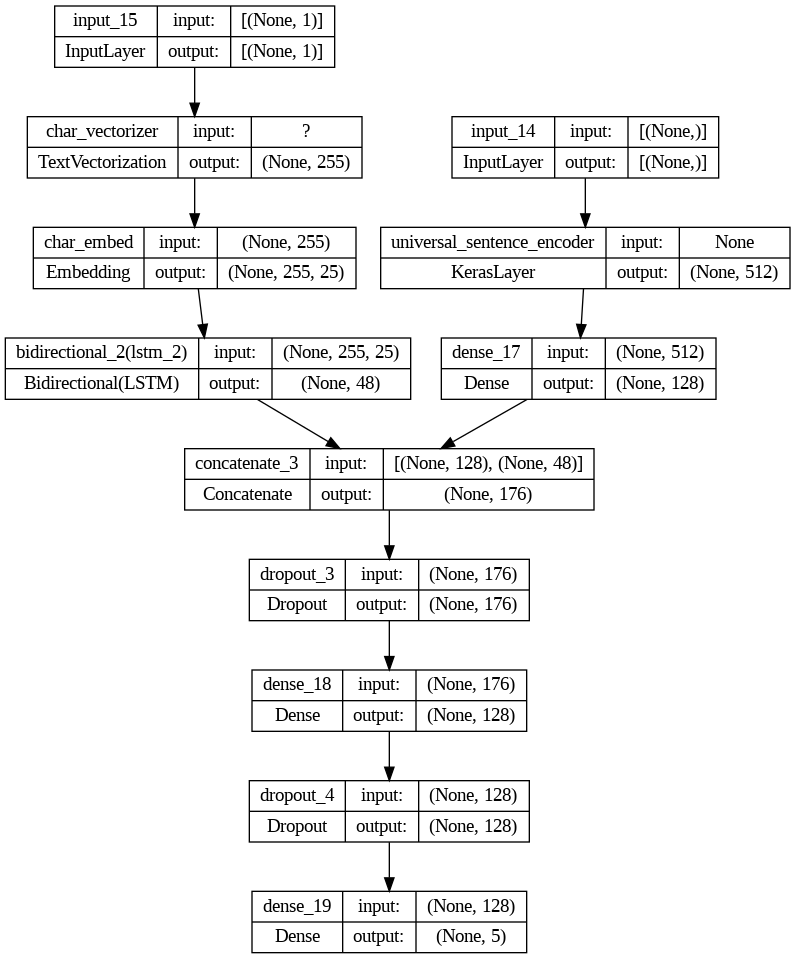

In [ ]:
from keras.utils import plot_model
plot_model(model_4,show_shapes=True)

In [ ]:
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), # section 4.2 of https://arxiv.org/pdf/1612.05251.pdf mentions using SGD but we'll stick with Adam
                metrics=["accuracy"])

In [ ]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars)) # make data
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot) # make labels
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)) # combine data and labels

# Prefetch and batch train data
train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

# Repeat same steps validation data
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))
val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_4.fit(train_char_token_dataset,
            epochs=10,
            validation_data=val_char_token_dataset,
            validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/10
469/469 [==============================] - 110s 223ms/step - loss: 0.2283 - accuracy: 0.9340 - val_loss: 0.1585 - val_accuracy: 0.9554
Epoch 2/10
469/469 [==============================] - 102s 218ms/step - loss: 0.1376 - accuracy: 0.9617 - val_loss: 0.1383 - val_accuracy: 0.9598
Epoch 3/10
469/469 [==============================] - 101s 214ms/step - loss: 0.1199 - accuracy: 0.9670 - val_loss: 0.1285 - val_accuracy: 0.9643
Epoch 4/10
469/469 [==============================] - 100s 214ms/step - loss: 0.1142 - accuracy: 0.9682 - val_loss: 0.1245 - val_accuracy: 0.9643
Epoch 5/10
469/469 [==============================] - 106s 226ms/step - loss: 0.1064 - accuracy: 0.9697 - val_loss: 0.1248 - val_accuracy: 0.9688
Epoch 6/10
469/469 [==============================] - 102s 218ms/step - loss: 0.0951 - accuracy: 0.9737 - val_loss: 0.1360 - val_accuracy: 0.9688
Epoch 7/10
469/469 [==============================] - 101s 215ms/step - loss: 0.0935 - accuracy: 0.9725 - val_loss: 0.1288 -

In [ ]:
model_4.evaluate(val_char_token_dataset)

79/79 [==============================] - 4s 48ms/step - loss: 0.0979 - accuracy: 0.9684


[0.097887322306633, 0.9684000015258789]

In [ ]:
model_4_probs = model_4.predict(val_char_token_dataset)

79/79 [==============================] - 6s 58ms/step


In [ ]:
model_4_preds = tf.argmax(model_4_probs,axis=1)

In [ ]:
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred = model_4_preds)
model_4_results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 96.84,
 'precision': 0.9635860709884578,
 'recall': 0.9684,
 'f1': 0.9659658882410486}

In [ ]:
train_df.head()

,target,text,line_number,total_lines
0,CONCLUSIONS,Low-dose oral prednisolone had both a short-te...,11,11
1,CONCLUSIONS,Results further suggest that attention mainten...,10,10
2,BACKGROUND,http://www.clinicaltrials.gov number NCT@ .,14,14
3,BACKGROUND,Data management and statistical analyses were ...,16,16
4,CONCLUSIONS,The findings suggest that recall with EM cause...,11,11


In [ ]:
train_df["line_number"].value_counts()

10    2149
11    2039
9     1940
12    1701
8     1365
13    1317
14     974
7      933
15     673
6      479
16     437
17     289
5      191
18     176
19     124
20      61
4       43
21      35
22      33
23      11
3        8
24       8
25       7
26       3
28       2
27       1
30       1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

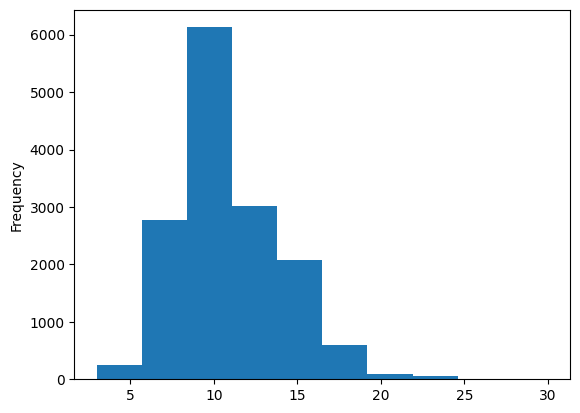

In [ ]:
train_df.line_number.plot.hist()

In [ ]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(dev_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [ ]:
train_line_numbers_one_hot.shape, train_line_numbers_one_hot[:20]

(TensorShape([15000, 15]),
 <tf.Tensor: shape=(20, 15), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0.,

In [ ]:
train_ = tf.one_hot(train_df['total_lines'].to_numpy(),depth=20)
test_ = tf.one_hot(dev_df['total_lines'].to_numpy(),depth=20)
valid_ = tf.one_hot(test_df['total_lines'].to_numpy(),depth=20)

## Tribid model
1. Character level embedding
2. Token - level model
3. Positional - level embedding

In [ ]:
token_i = tf.keras.layers.Input(shape=[],dtype='string')
x = tf_hub_embedding_layer(token_i)
token_op = tf.keras.layers.Dense(128, activation='tanh')(x)
token_model = tf.keras.Model(token_i,token_op)

char_ip = tf.keras.layers.Input(shape=(1,),dtype=tf.string)
char_v = char_vectorizer(char_ip)
print(char_v.shape)
char_emb = char_embed(char_v)
bidirection = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24))(char_emb)
char_model = tf.keras.Model(char_ip,bidirection)

line_ip = tf.keras.layers.Input(shape=(15,), dtype=tf.int32)
x = tf.keras.layers.Dense(32,activation='tanh')(line_ip)
line_embeddd = tf.keras.Model(line_ip,x)

total_lines_ip = tf.keras.layers.Input(shape=(20,), dtype=tf.int32)
y = tf.keras.layers.Dense(32,activation='tanh')(total_lines_ip)
total_line_embedd = tf.keras.Model(total_lines_ip,y)

(None, 255)


In [ ]:
combined_ct = tf.keras.layers.Concatenate()([token_model.output, char_model.output])

In [ ]:
z = tf.keras.layers.Dense(256,activation='tanh')(combined_ct)
z = tf.keras.layers.Dropout(0.5)(z)

In [ ]:
z = tf.keras.layers.Concatenate()([line_embeddd.output,total_line_embedd.output,z])

In [ ]:
output = tf.keras.layers.Dense(5,activation='softmax')(z)
model_5 = tf.keras.Model(inputs=[line_embeddd.input,
                                 total_line_embedd.input,
                                 token_model.input,
                                 char_model.input],outputs=output)

In [ ]:
model_5.summary()

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 1)]          0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None,)]            0           []                               
                                                                                                  
 char_vectorizer (TextVectoriza  (None, 255)         0           ['input_17[0][0]']               
 tion)                                                                                            
                                                                                                  
 universal_sentence_encoder (Ke  (None, 512)         256797824   ['input_16[0][0]']        

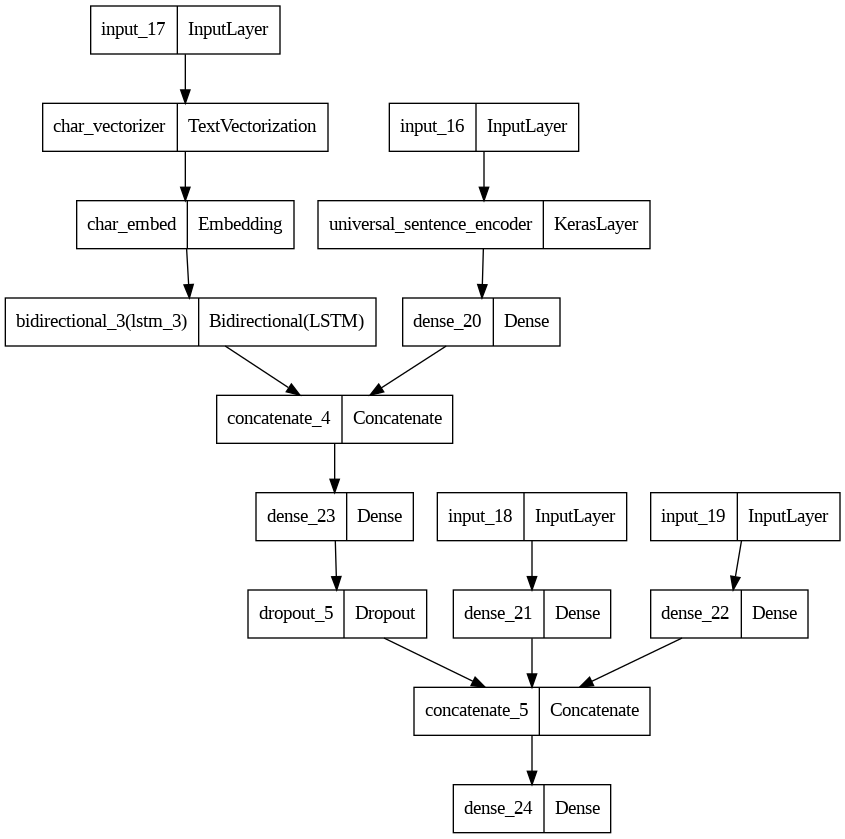

In [ ]:
from keras.utils import plot_model
plot_model(model_5)

In [ ]:
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer='adam',
                metrics=['accuracy'])

In [ ]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                            train_,
                                                            train_sentences,
                                                            train_chars))
train_labels_ = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)

In [ ]:
train_dataset = tf.data.Dataset.zip((train_char_token_data,train_labels_))

dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_char_token_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_one_hot,
                                                            test_,
                                                            test_sentences,
                                                            test_chars))
test_labels_ = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_dataset = tf.data.Dataset.zip((test_char_token_data,test_labels_))

test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                            valid_,
                                                            val_sentences,
                                                            val_chars))
val_labels_ = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_dataset = tf.data.Dataset.zip((val_char_token_data,val_labels_))
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
model_5.fit(dataset,
            epochs=10,
            validation_data=val_dataset,
            validation_steps=int(0.1*len(val_dataset)))

Epoch 1/10
469/469 [==============================] - 109s 219ms/step - loss: 0.7716 - accuracy: 0.9454 - val_loss: 0.7568 - val_accuracy: 0.9464
Epoch 2/10
469/469 [==============================] - 101s 215ms/step - loss: 0.7417 - accuracy: 0.9621 - val_loss: 0.7441 - val_accuracy: 0.9643
Epoch 3/10
469/469 [==============================] - 100s 212ms/step - loss: 0.7358 - accuracy: 0.9652 - val_loss: 0.7379 - val_accuracy: 0.9643
Epoch 4/10
469/469 [==============================] - 101s 215ms/step - loss: 0.7329 - accuracy: 0.9663 - val_loss: 0.7382 - val_accuracy: 0.9688
Epoch 5/10
469/469 [==============================] - 100s 213ms/step - loss: 0.7307 - accuracy: 0.9668 - val_loss: 0.7355 - val_accuracy: 0.9688
Epoch 6/10
469/469 [==============================] - 99s 212ms/step - loss: 0.7297 - accuracy: 0.9689 - val_loss: 0.7361 - val_accuracy: 0.9688
Epoch 7/10
469/469 [==============================] - 100s 214ms/step - loss: 0.7276 - accuracy: 0.9685 - val_loss: 0.7343 - 

In [ ]:
results = model_5.evaluate(test_dataset)

79/79 [==============================] - 5s 66ms/step - loss: 0.7169 - accuracy: 0.9744


In [ ]:
model_5_pred_probs = model_5.predict(test_dataset)
model_5_pred_probs

79/79 [==============================] - 6s 61ms/step


array([[0.02782972, 0.7998131 , 0.05819782, 0.04800453, 0.06615479],
       [0.0338618 , 0.854118  , 0.02598639, 0.03577188, 0.05026191],
       [0.02287346, 0.8747497 , 0.03024072, 0.03476479, 0.03737132],
       ...,
       [0.02591364, 0.8540926 , 0.04891944, 0.03315381, 0.03792062],
       [0.03320625, 0.8827322 , 0.02562843, 0.03206242, 0.02637076],
       [0.08352681, 0.763112  , 0.05332416, 0.05507485, 0.04496223]],
      dtype=float32)

In [ ]:
final_results = tf.argmax(model_5_pred_probs,axis=1)

In [ ]:
model_final_results = calculate_results(y_true=test_labels_encoded,
                                        y_pred=final_results)
model_final_results

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 97.44,
 'precision': 0.9727782256516564,
 'recall': 0.9744,
 'f1': 0.9735848485835795}

In [ ]:
import pandas as pd
all_models_results = pd.DataFrame({"Multinomial_NaiveBayes" : base_results,
                                   "Custom_token_embedding" : model_1_results,
                                   "Universal_sentence_encoder": model_2_results,
                                   "Character-level embedding" : model_3_results,
                                   "Character-levl + Token-level" : model_4_results,
                                   "Character-level + token-level + Positional-level" : model_final_results})

In [ ]:
all_models_results = all_models_results.transpose()
all_models_results

,accuracy,precision,recall,f1
Multinomial_NaiveBayes,93.64,0.917629,0.9364,0.926837
Custom_token_embedding,96.92,0.970002,0.9692,0.969506
Universal_sentence_encoder,96.56,0.960799,0.9656,0.963174
Character-level embedding,76.76,0.661534,0.7676,0.698096
Character-levl + Token-level,96.84,0.963586,0.9684,0.965966
Character-level + token-level + Positional-level,97.44,0.972778,0.9744,0.973585


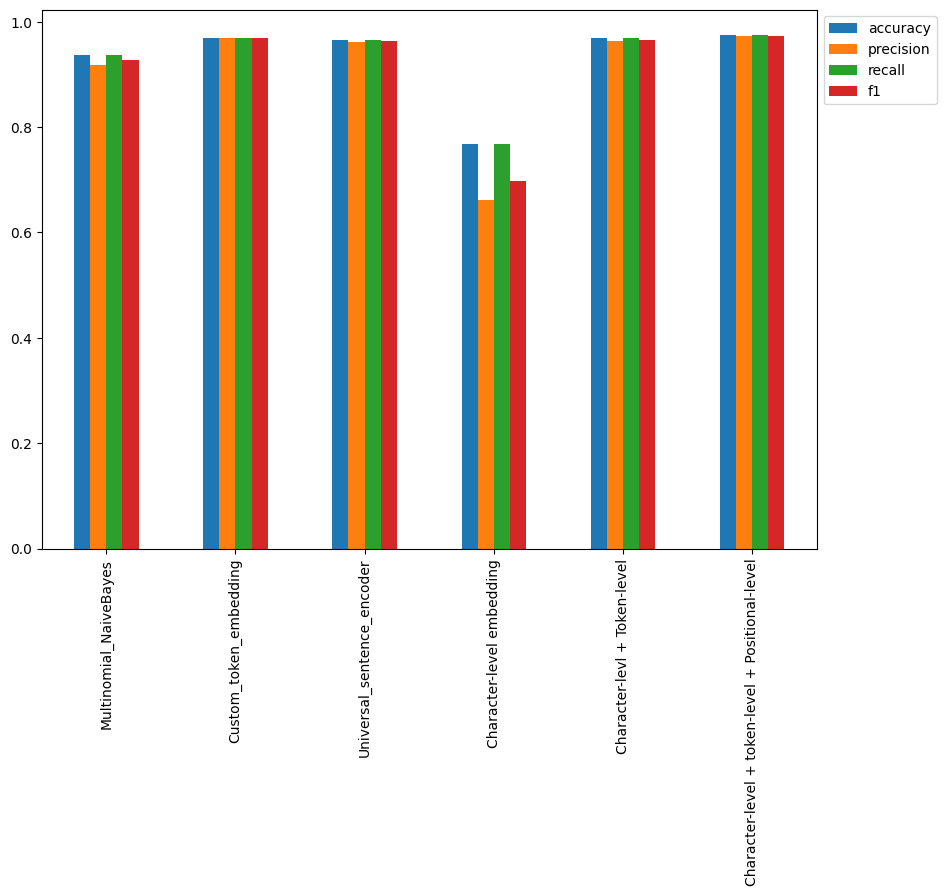

In [ ]:
all_models_results['accuracy'] = all_models_results['accuracy']/100
all_models_results.plot(kind='bar',figsize=(10,7)).legend(bbox_to_anchor=(1.0,1.0))

In [ ]:
model_5.save("Skimlit_tribrid_model")

In [ ]:
abs = """
Mental illness, including depression, anxiety and bipolar disorder, accounts for a significant proportion of global disability and poses a substantial social, economic and heath burden. Treatment is presently dominated by pharmacotherapy, such as antidepressants, and psychotherapy, such as cognitive behavioural therapy; however, such treatments avert less than half of the disease burden, suggesting that additional strategies are needed to prevent and treat mental disorders. There are now consistent mechanistic, observational and interventional data to suggest diet quality may be a modifiable risk factor for mental illness. This review provides an overview of the nutritional psychiatry field. It includes a discussion of the neurobiological mechanisms likely modulated by diet, the use of dietary and nutraceutical interventions in mental disorders, and recommendations for further research. Potential biological pathways related to mental disorders include inflammation, oxidative stress, the gut microbiome, epigenetic modifications and neuroplasticity. Consistent epidemiological evidence, particularly for depression, suggests an association between measures of diet quality and mental health, across multiple populations and age groups; these do not appear to be explained by other demographic, lifestyle factors or reverse causality. Our recently published intervention trial provides preliminary clinical evidence that dietary interventions in clinically diagnosed populations are feasible and can provide significant clinical benefit. Furthermore, nutraceuticals including n-3 fatty acids, folate, S-adenosylmethionine, N-acetyl cysteine and probiotics, among others, are promising avenues for future research. Continued research is now required to investigate the efficacy of intervention studies in large cohorts and within clinically relevant populations, particularly in patients with schizophrenia, bipolar and anxiety disorders.
 """

In [ ]:
import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
def preprocess(text):
  input = sent_tokenize(text)
  return input

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
sample_text = preprocess(abs)

In [ ]:
sample_text

['\nMental illness, including depression, anxiety and bipolar disorder, accounts for a significant proportion of global disability and poses a substantial social, economic and heath burden.',
 'Treatment is presently dominated by pharmacotherapy, such as antidepressants, and psychotherapy, such as cognitive behavioural therapy; however, such treatments avert less than half of the disease burden, suggesting that additional strategies are needed to prevent and treat mental disorders.',
 'There are now consistent mechanistic, observational and interventional data to suggest diet quality may be a modifiable risk factor for mental illness.',
 'This review provides an overview of the nutritional psychiatry field.',
 'It includes a discussion of the neurobiological mechanisms likely modulated by diet, the use of dietary and nutraceutical interventions in mental disorders, and recommendations for further research.',
 'Potential biological pathways related to mental disorders include inflammati

In [ ]:
model_0.predict(sample_text)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])